In [1]:
%pip install einops
%pip install wandb

     |████████████████████████████████| 1.8MB 7.3MB/s 
     |████████████████████████████████| 102kB 11.2MB/s 
     |████████████████████████████████| 174kB 35.4MB/s 
     |████████████████████████████████| 133kB 34.8MB/s 
     |████████████████████████████████| 71kB 7.8MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=66b631e032ce6a2e50ed5459509477d449fd782c5c24599bffd7ba7a23772daa
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=569abbafa0ca787d20c486b5d7c37c64d84501ceb36b053fc85d68ce4a33a1fa
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
Successfully built pathtools subprocess32


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/MyDrive/'Colab Notebooks'/tensorflow_workspace

/content/drive/MyDrive/Colab Notebooks/tensorflow_workspace


In [4]:
#NesT
config={
    "epochs": 64,
    "batch_size": 256,
    "lr" : 1e-6,
    "image_size" : 32,
    "channels" : 3,
    "num_classes" : 10,
    "hidden_dim" : 128,
    "size_blocks" : 4,
    "patch_size" : 4,
    "depth" : 3,
    "d_ff" : 1024,
    "dataset" : 'CIFAR10',
    }

In [5]:
from model.MLP_Mixer_model import MLP_Mixer1_build
from model.gMLP_model import build_gMLP
from model.NesT_model import build_nesT

#modelの選択
#model = MLP_Mixer1_build(**config)
#model = build_gMLP(**config)
model = build_nesT(**config)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
rearrange (Rearrange)        (None, 16, 8, 8, 3)       0         
_________________________________________________________________
rearrange_1 (Rearrange)      (None, 16, 4, 4, 12)      0         
_________________________________________________________________
dense (Dense)                (None, 16, 4, 4, 128)     1536      
_________________________________________________________________
rearrange_2 (Rearrange)      (None, 16, 16, 128)       0         
_________________________________________________________________
g_mlp_block (gMLPBlock)      (None, 16, 16, 128)       198160    
_________________________________________________________________
tokens2_img (Tokens2Img)     (None, 16, 16, 128)       0     

In [6]:
import wandb
#wandb.init(config=config, project="cifar10_MLP_Mixer", entity='NoguNogu',name='nesT')
wandb.init(config=config, project="test", entity='NoguNogu',name='nesT')

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [7]:
from myImageDataGenerator import get_dataset
from myImageDataGenerator import PatchImageDataGenerator

dataset = get_dataset(**config)
x_train, x_val, y_train, y_val = dataset.setting()

train_datagen = PatchImageDataGenerator(rotation_range=5,width_shift_range=0.1,height_shift_range=0.1, horizontal_flip=True)
train_generator = train_datagen.flow(x_train, y_train, batch_size=config['batch_size'])

170500096/170498071 [==============================] - 4s 0us/step


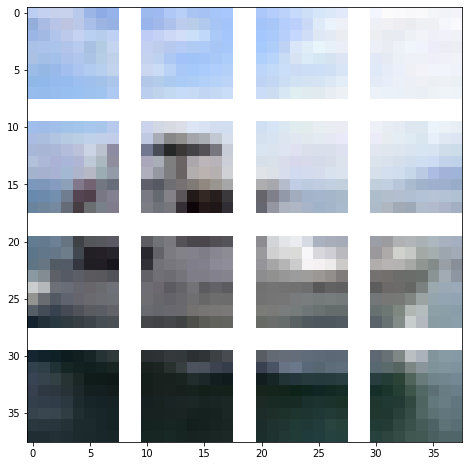

In [8]:
from utils.visualize import Visualize_patch, Visual_weight

Visualize_patch(x_train, **config)

In [9]:
from wandb.keras import WandbCallback
import tensorflow as tf

def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.2)

N_train = x_train.shape[0]
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_generator,
                    validation_data=(x_val, y_val),
                    steps_per_epoch=N_train//config['batch_size'],
                    epochs= config['epochs'],
                    verbose=1,
                    callbacks=[callback,
                               WandbCallback()])

Epoch 1/64
175/175 [==============================] - 49s 176ms/step - loss: 2.1550 - accuracy: 0.2001 - val_loss: 1.7973 - val_accuracy: 0.3362
Epoch 2/64
175/175 [==============================] - 29s 168ms/step - loss: 1.6361 - accuracy: 0.3998 - val_loss: 1.4632 - val_accuracy: 0.4604
Epoch 3/64
175/175 [==============================] - 29s 166ms/step - loss: 1.4030 - accuracy: 0.4909 - val_loss: 1.3502 - val_accuracy: 0.5068
Epoch 4/64
175/175 [==============================] - 29s 166ms/step - loss: 1.2657 - accuracy: 0.5426 - val_loss: 1.2004 - val_accuracy: 0.5620
Epoch 5/64
175/175 [==============================] - 29s 168ms/step - loss: 1.1801 - accuracy: 0.5784 - val_loss: 1.1355 - val_accuracy: 0.5872
Epoch 6/64
175/175 [==============================] - 29s 167ms/step - loss: 1.1105 - accuracy: 0.6035 - val_loss: 1.0493 - val_accuracy: 0.6240
Epoch 7/64
175/175 [==============================] - 29s 167ms/step - loss: 1.0523 - accuracy: 0.6241 - val_loss: 1.0126 - val_ac

In [ ]:
load_model = tf.keras.models.load_model("./save/nesT_Train", 
                                        custom_objects = {"gMLPBlock": gMLPBlock})

NameError: ignored